## 라인스튜디오 서류전형을 통과하신 여러분을 환영합니다!

**"라인 버블2"** 게임의 **신규 가입 유저(NRU)** 데이터를 활용하여 Python을 통해 간단한 지표들을 추출해보려고 합니다.
아래 문제들을 순서대로 풀어주세요.
1. 개인정보 우려가 있는 유저키 값은 모두 제외되었습니다.
2. 모든 수치 데이터는 재가공한 뒤 변수로 변경하여 제공 되었습니다.

**데이터 셋**

* 파일 포맷: CSV
* 샘플 수: 55,809건
* feature 수: 22개
    * 1: os 타입
    * 2: 국가
    * 3: 로그인 타입
    * 4: D+1일차 접속여부
    * 5: D+3일차 접속여부
    * 6: D+5일차 접속여부
    * 7: D+7일차 접속여부
    * 8: D+9일차 접속여부
    * 9: D+11일차 접속여부
    * 10: D+14일차 접속여부
    * 11: 최종 클리어 스테이지
    * 12: 마지막으로 도전한 스테이지
    * 13: 획득한 불꽃 총 개수
    * 14: 사용한 불꽃 총 개수
    * 15: 코인 교환에 사용한 루비량
    * 16: 버디 슬롯 개방에 사용한 루비량
    * 17: 에피소드 오픈에 사용한 루비량
    * 18: 불꽃 충전에 사용한 루비량
    * 19: 버디 뽑기(가챠)에 사용한 루비량
    * 20: 스테이지 플레이에 필요한 아이템 구매에 사용한 루비량
    * 21: 구매한 상품명
    * 22: 구매 횟수
    

In [62]:
# import를 활용해 필요한 라이브러리 읽어오기
import pandas as pd
import numpy as np

# 결과 창에서 에러 메시지 제거
import warnings
warnings.filterwarnings(action='ignore')

# boxplot 그림
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm

font_path = 'C:/Windows/Fonts/malgun.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)

sns.set_style("whitegrid")

# matplotlib
from matplotlib import rc
# y-axis in bold
rc('font', weight='bold')

# modeling
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
seed = 110
np.random.seed(seed)

In [63]:
# 데이터 로딩
# 알맞은 경로를 지정해주세요
data = pd.read_csv("line_studio_nru_data.csv", sep=",", header=None)

# data 변수에 할당된 데이터의 행렬 사이즈를 출력합니다.
# 출력은 (row, column) 으로 표시됩니다.
print(data.shape)

# head()로 data 데이터의 상위 5개를 띄웁니다.
data.head()

(55809, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,Android,JP,LINE,0,0,0,0,0,0,0,...,41,41,0,0,0,0,0,32,NaN,NaN
1,Android,TH,LINE,1,0,0,0,0,0,0,...,12,8,0,0,0,0,0,0,NaN,NaN
2,iOS,TW,LINE,1,1,1,1,1,1,1,...,17,17,0,0,0,0,0,6,NaN,NaN
3,iOS,TW,LINE,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,NaN,NaN
4,iOS,TW,LINE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [64]:
# data 변수명 feature 수에 맞게 rename
data.columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
data.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,Android,JP,LINE,0,0,0,0,0,0,0,...,41,41,0,0,0,0,0,32,NaN,NaN
1,Android,TH,LINE,1,0,0,0,0,0,0,...,12,8,0,0,0,0,0,0,NaN,NaN
2,iOS,TW,LINE,1,1,1,1,1,1,1,...,17,17,0,0,0,0,0,6,NaN,NaN
3,iOS,TW,LINE,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,NaN,NaN
4,iOS,TW,LINE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [65]:
data=data.loc[data[2]=='JP']

In [73]:
retention=pd.DataFrame(round(data[[4,5,6,7,8,9,10]].sum()/len(data),4)).reset_index()
retention.columns=['D+','retention']
retention

,D+,retention
0,4,0.4083
1,5,0.2831
2,6,0.2473
3,7,0.2307
4,8,0.2102
5,9,0.1963
6,10,0.1891


### 1. 신규유저 기본 지표 분석

우리 게임에 들어온 신규유저를 볼 때 가장 관심이 있는 지표는 **"잔존율"** 이라고 할 수 있습니다. 잔존율이란 신규 유저중 다음날, 그 다음날, 2주뒤, 1개월 뒤에도 우리 게임에 접속하였는지를 측정하는 지표이며, 리텐션(Retention)이라고도 합니다. 전체 가입 유저 중 D+N일차 이후에도 접속한 유저의 비율로 계산 가능합니다.


**필요한 컬럼**
* 1: os 타입
* 4: D+1일차 접속여부
* 5: D+3일차 접속여부
* 6: D+5일차 접속여부
* 7: D+7일차 접속여부
* 8: D+9일차 접속여부
* 9: D+11일차 접속여부
* 10: D+14일차 접속여부
* 11: 최종 클리어 스테이지

    

**1. 신규유저의 D+1, 3, 5, 7, 9, 11, 14 잔존율(Retention)을 계산해주세요.**

(잔존율 = D+N 잔존유저수 / 전체 가입유저수)

In [5]:
retention=pd.DataFrame(round(data[[4,5,6,7,8,9,10]].sum()/len(data),4)).reset_index()
retention.columns=['D+','retention']
retention.iloc[0,0]='D+1'
retention.iloc[1,0]='D+3'
retention.iloc[2,0]='D+5'
retention.iloc[3,0]='D+7'
retention.iloc[4,0]='D+9'
retention.iloc[5,0]='D+11'
retention.iloc[6,0]='D+14'
retention

,D+,retention
0,D+1,0.4083
1,D+3,0.2831
2,D+5,0.2473
3,D+7,0.2307
4,D+9,0.2102
5,D+11,0.1963
6,D+14,0.1891


**2. OS 타입별 신규유저의 D+1, 3, 5, 7, 9, 11, 14 잔존율(Retention)을 계산해주세요.**


In [6]:
# OS 타입별 신규유저의 D+1, 3, 5, 7, 9, 11, 14 잔존율(Retention)
os_retention=round(data.groupby([1])[[4,5,6,7,8,9,10]].sum()/len(data), 6).sort_values(by=[4,5,6], axis=0, ascending=False)
os_retention.columns=['D+1','D+3','D+5','D+7','D+9','D+11','D+14']
os_retention

,D+1,D+3,D+5,D+7,D+9,D+11,D+14
1,,,,,,,
iOS,0.220578,0.165253,0.147692,0.138571,0.128010,0.119930,0.114729
Android,0.187695,0.117889,0.099568,0.092167,0.082167,0.076406,0.074326


이번에는 가입 당일 유저들이 최종적으로 몇 스테이지까지 도달하는지 확인해보려고 합니다. 

**3. 신규유저의 가입 당일 최종 도달 스테이지의 5 number summary를 계산해주세요.**



In [7]:
quartiles = np.percentile(data[11].dropna(),[25,50,75])
data_min, data_max = data[11].min(), data[11].max()
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)

Min: 0.000
Q1: 5.000
Median: 10.000
Q3: 18.000
Max: 790.000


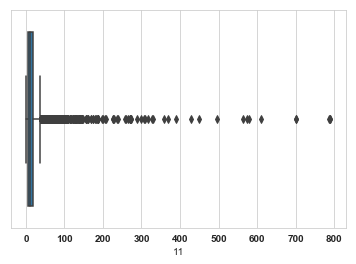

In [8]:
# boxplot 그림
sns.boxplot(data[11].dropna())

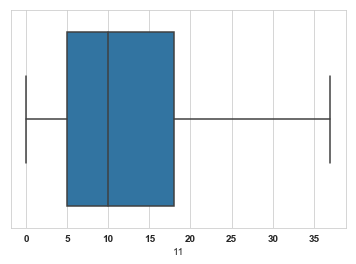

In [9]:
# 이상치를 안보이게 한 후 boxplot 그림
sns.boxplot(data[11].dropna(),showfliers=False)

**4. 신규유저의 가입 당일 최종 도달 스테이지별 유저 분포를 그래프로 표현해주세요.**

Text(0.5,1,'최종 도달 스테이지별 유저 분포')

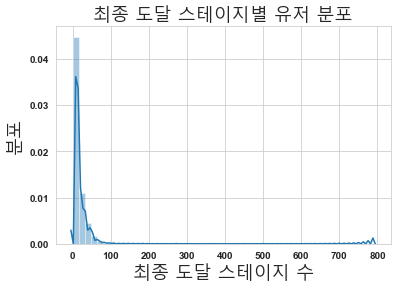

In [10]:
# 신규유저의 가입 당일 최종 도달 스테이지별 유저 분포를 그래프
sns.distplot(data[11].dropna())
plt.ylabel('분포', fontproperties=fontprop)
plt.xlabel('최종 도달 스테이지 수', fontproperties=fontprop)
plt.title('최종 도달 스테이지별 유저 분포', fontproperties=fontprop)

In [11]:
# 이상치를 제외한 최대값, 최소값 
IQR = quartiles[2] - quartiles[0]
upper_limit = quartiles[2] + 1.5*IQR
lower_limit = quartiles[0] - 1.5*IQR

print('상한 :',upper_limit)
print('하한 :',lower_limit)

상한 : 37.5
하한 : -14.5


In [12]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,Android,JP,LINE,0,0,0,0,0,0,0,...,41,41,0,0,0,0,0,32,NaN,NaN
12,Android,JP,LINE,1,0,0,1,1,0,0,...,14,9,0,0,0,0,0,0,NaN,NaN
13,Android,JP,LINE,0,1,1,1,1,1,1,...,15,10,0,0,0,0,0,0,NaN,NaN
17,iOS,JP,LINE,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,NaN,NaN
18,iOS,JP,LINE,1,0,0,0,0,0,0,...,14,13,0,0,0,0,0,0,NaN,NaN


In [13]:
data[data[11]>float(upper_limit)] = 0
data[data[11]<float(lower_limit)] = 0

Text(0.5,1,'최종 도달 스테이지별 유저 분포')

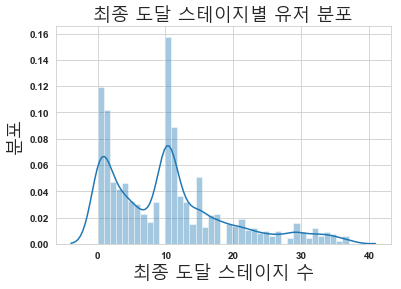

In [14]:
sns.distplot(data[11].dropna())
plt.ylabel('분포', fontproperties=fontprop)
plt.xlabel('최종 도달 스테이지 수', fontproperties=fontprop)
plt.title('최종 도달 스테이지별 유저 분포', fontproperties=fontprop)

**5. 신규유저의 가입 당일 최종 도달 스테이지별 유저수와 비중(%)을 계산해주세요.**

In [15]:
# 신규유저들 중 플레이한 사람들 수
# 신규유저 가입자 중 플레이한 값이 없는 (NAN)사람들 제외
len(data[11].dropna())

18765

In [16]:
# 신규유저의 가입 당일 최종 도달 스테이지별 유저수와 비중(%) 계산
# 신규가입 유저 중 한 결측치(NAN) 제외한 후 비중(%)을 계산
users=data[11].dropna().value_counts().reset_index(name='counts')
users.columns=['Final stage','counts']
users['P']=users['counts']/users['counts'].sum()
users.head()

,Final stage,counts,P
0,10.0,2669,0.142233
1,0.0,2018,0.107541
2,1.0,1719,0.091607
3,11.0,1506,0.080256
4,15.0,865,0.046096


**6. 최종 도달 스테이지를 기준으로 "스테이지 구분" 이라는 변수를 생성해주세요.**

최종스테이지 기준으로 아래와 같이 구분
* 0 : 0
* 1~5 : 1~5
* 6~9 : 6~9
* 10~14 : 10~14
* 15~19 : 15~19
* 20~ : 20~




In [17]:
# 최종 도달 스테이지 기준으로 '스테이지 구분' 변수 생성
users.loc[(users['Final stage']==0),'스테이지 구분']=0
users.loc[(users['Final stage']>=1)&(users['Final stage']<6),'스테이지 구분']='1~5'
users.loc[(users['Final stage']>=6)&(users['Final stage']<=9),'스테이지 구분']='6~9'
users.loc[(users['Final stage']>=10)&(users['Final stage']<=14),'스테이지 구분']='10~14'
users.loc[(users['Final stage']>=15)&(users['Final stage']<=19),'스테이지 구분']='15~19'
users.loc[(users['Final stage']>=20),'스테이지 구분']='20~'
users.head()

,Final stage,counts,P,스테이지 구분
0,10.0,2669,0.142233,10~14
1,0.0,2018,0.107541,0
2,1.0,1719,0.091607,1~5
3,11.0,1506,0.080256,10~14
4,15.0,865,0.046096,15~19


**7. 위에서 생성한 "스테이지 구분" 별 유저수와 비중(%)을 계산해주세요.**

In [18]:
# "스테이지 구분"별 유저수와 비중(%) 계산
# 신규가입 유저 중 결측치(NA) 제외 후 비중(%)을 계산
categorical_users=users.groupby(['스테이지 구분'])[['counts']].sum().reset_index()
categorical_users['P']=categorical_users['counts']/categorical_users['counts'].sum()
categorical_users=categorical_users.reindex([0,3,5,1,2,4])
categorical_users.index = range(len(categorical_users))
categorical_users

,스테이지 구분,counts,P
0,0,2018,0.107541
1,1~5,4566,0.243325
2,6~9,1721,0.091713
3,10~14,5592,0.298002
4,15~19,2083,0.111005
5,20~,2785,0.148415


### 2. 구매지표 분석

가입 당일 과금하며 게임에 몰입하는 유저들은 얼마나 있는지, 구매한다면 어떤 상품을 주로 구매하고 있는지 살펴보려고 합니다.

**필요한 컬럼**

* 21: 구매한 상품명
* 22: 구매 횟수


In [19]:
categorical_users['스테이지 구분'].unique()

array([0.0, '1~5', '6~9', '10~14', '15~19', '20~'], dtype=object)

In [20]:
# 가입 당일 과금하여 게임에 몰입하는 유저들은 39명이 있다.
print('가입 당일 과금하여 구입한 상품:',data[21].unique())
pd.DataFrame(data[22].value_counts())

가입 당일 과금하여 구입한 상품: [nan 'Product 4' 0 'Product 11' 'Product 8' 'Product 6' 'Product 5'
 'Product 13' 'Product 14' 'Product 15' 'Product 9' 'Product 10'
 'Product 2']


,22
0.0,1482
1.0,79
3.0,1
4.0,1


**1. 구매한 경우 1 구매하지 않은 경우 0 으로 나타나는 "구매여부"라는 변수를 생성하고, 전체 구매유저수와 구매하지 않은 유저수를 각각 계산해주세요.**

(구매유저 = 구매횟수가 1 이상인 유저)

In [21]:
# 구매여부 열 생성
purchase_i=data[[21,22,11,12]]
# 결측값은 0으로 치환
purchase_i.fillna(0,inplace=True)
purchase_i.loc[(purchase_i[22]==0),'구매여부']=0
purchase_i.loc[(purchase_i[22]>0),'구매여부']=1
purchase_i.head()

,21,22,11,12,구매여부
0,0,0.0,29.0,30,0.0
12,0,0.0,9.0,9,0.0
13,0,0.0,10.0,10,0.0
17,0,0.0,0.0,0,0.0
18,0,0.0,8.0,9,0.0


In [22]:
# 가입 당일 구매한 유저수(1)와 구매하지 않은 유저수(0)
purchase_i['구매여부'].value_counts()
# 구매한 유저수: 39명 
# 구매하지 않은 유저수: 26240명

0.0    24917
1.0       81
Name: 구매여부, dtype: int64

**2. "구매 여부" 별 최종 도달 스테이지 분포를 Boxplot으로 표현.**

Text(0.5,1,'Boxplot')

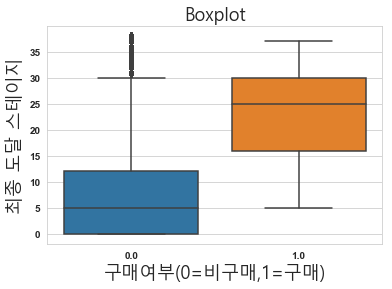

In [23]:
sns.boxplot(x='구매여부',y=12, data=purchase_i)
plt.ylabel('최종 도달 스테이지', fontproperties=fontprop)
plt.xlabel('구매여부(0=비구매,1=구매)', fontproperties=fontprop)
plt.title('Boxplot', fontproperties=fontprop)

**3. "스테이지 구분"별 구매유저수와 평균 구매횟수를 계산해주세요.**

In [24]:
# '구매여부','구매횟수','최종 도달 스테이지','users_counts' 표 생성
a=purchase_i.groupby(["구매여부",22,12])[12].count().reset_index(name='counts')
a.columns=['구매여부','구매횟수','최종 도달 스테이지','users_counts']

In [25]:
# 스테이지 구분 열 추가하기 
a.loc[(a['최종 도달 스테이지']==0),'스테이지 구분']=0
a.loc[(a['최종 도달 스테이지']>=1)&(a['최종 도달 스테이지']<6),'스테이지 구분']='1~5'
a.loc[(a['최종 도달 스테이지']>=6)&(a['최종 도달 스테이지']<=9),'스테이지 구분']='6~9'
a.loc[(a['최종 도달 스테이지']>=10)&(a['최종 도달 스테이지']<=14),'스테이지 구분']='10~14'
a.loc[(a['최종 도달 스테이지']>=15)&(a['최종 도달 스테이지']<=19),'스테이지 구분']='15~19'
a.loc[(a['최종 도달 스테이지']>=20),'스테이지 구분']='20~'
a.head()

,구매여부,구매횟수,최종 도달 스테이지,users_counts,스테이지 구분
0,0.0,0.0,0,8101,0
1,0.0,0.0,1,1842,1~5
2,0.0,0.0,2,739,1~5
3,0.0,0.0,3,654,1~5
4,0.0,0.0,4,735,1~5


In [26]:
# "스테이지 구분"별 구매유저수와 평균 구매횟수 계산
categorical_purchase=a.groupby(['스테이지 구분','구매여부']).agg({'users_counts':'sum','구매횟수':'mean'}).reset_index()
cateogrical_purchase1=categorical_purchase.loc[categorical_purchase['구매여부'] != 0]

In [27]:
# index 정리 및 스테이지 구분 순서 정리
cateogrical_purchase1=cateogrical_purchase1.reindex([6,10,2,4,8])
cateogrical_purchase1.index = range(len(cateogrical_purchase1))
cateogrical_purchase1

,스테이지 구분,구매여부,users_counts,구매횟수
0,1~5,1.0,1.0,1.000000
1,NaN,NaN,NaN,NaN
2,10~14,1.0,17.0,1.000000
3,15~19,1.0,14.0,1.000000
4,20~,1.0,49.0,1.333333


**4. 상품별 구매유저수를 계산하고, 구매유저수가 가장 많은 상품부터 순서대로 나열해주세요.**

In [28]:
# 상품별 품목과 구매횟수 열 추출 후 구매횟수가 있는 유저들만 gathering 
purchase_i=data[[21,22]]
purchase_i.fillna(0,inplace=True)
purchase_i=purchase_i.loc[purchase_i[21] != 0]

In [29]:
# 상품별 구매유저수를 계산하고, 구매유저수가 가장 많은 상품부터 순서대로 나열
purchase_i.groupby([21])[22].count().reset_index(name='counts').sort_values(by=['counts'], axis=0, ascending=False)

,21,counts
6,Product 4,46
9,Product 8,14
1,Product 11,7
2,Product 13,3
7,Product 5,3
0,Product 10,2
8,Product 6,2
3,Product 14,1
4,Product 15,1
5,Product 2,1


### 3. 재화 지표 분석

**"버블2"**에서 사용되는 여러 재화들 중 두 가지 중요한 재화에 대해 살펴보겠습니다.

먼저, **"루비"**는 게임 내 메인 캐시역할을 하는 재화입니다. 주로 과금을 통해 획득할 수 있고, 가끔 보상이나 버디 스킬을 통해 획득할 수 있습니다.
루비 사용처를 파악하면 유저들이 어떤 측면에서 과금 니즈를 느끼는지 확인할 수 있습니다.

그리고 **"불꽃"**이라는 재화는 게임 내 메인 스테이지에 입장하기 위한 열쇠 역할을 하는 재화입니다. 불꽃을 모두 사용하면 시간이 지남에 따라 최대 5개까지 자동으로 충전되고, 그 외 필요한 불꽃은 루비로 구매할 수 있고, 이벤트를 통해서도 가끔 획득할 수 있습니다.

**필요한 컬럼**

* 13: 획득한 불꽃 총 개수
* 14: 사용한 불꽃 총 개수
* 15: 코인 교환에 사용한 루비량
* 16: 버디 슬롯 개방에 사용한 루비량
* 17: 에피소드 오픈에 사용한 루비량
* 18: 불꽃 충전에 사용한 루비량
* 19: 버디 뽑기(가챠)에 사용한 루비량
* 20: 스테이지 플레이에 필요한 아이템 구매에 사용한 루비량



**1. 루비의 각 소비처(컬럼 15~20번) 별 루비를 사용한 유저수, 평균 사용량을 계산해주세요.**

In [30]:
print('컬럼15번 루비를 사용한 유저수: ',data[data[15]>0][15].count())
print('컬럼15번 루비를 사용한 평균 사용량: ', round(data[data[15]>0][15].mean(),4))
print('')
print('컬럼16번 루비를 사용한 유저수: ',data[data[16]>0][16].count())
print('컬럼16번 루비를 사용한 평균 사용량: ', round(data[data[16]>0][16].mean(),4))
print('') # 컬럼 17번은 데이터가 오류가 있음
print('컬럼17번 루비를 사용한 유저수: ',data[data[17]>0][17].count())
print('컬럼17번 루비를 사용한 평균 사용량: ', round(data[data[17]>0][17].mean(),4))
print('')
print('컬럼18번 루비를 사용한 유저수: ',data[data[18]>0][18].count())
print('컬럼18번 루비를 사용한 평균 사용량: ', round(data[data[18]>0][18].mean(),4))
print('')
print('컬럼19번 루비를 사용한 유저수: ',data[data[19]>0][19].count())
print('컬럼19번 루비를 사용한 평균 사용량: ', round(data[data[19]>0][19].mean(),4))
print('')
print('컬럼20번 루비를 사용한 유저수: ',data[data[20]>0][20].count())
print('컬럼20번 루비를 사용한 평균 사용량: ', round(data[data[20]>0][20].mean(),4))

컬럼15번 루비를 사용한 유저수:  45
컬럼15번 루비를 사용한 평균 사용량:  12.2222

컬럼16번 루비를 사용한 유저수:  16
컬럼16번 루비를 사용한 평균 사용량:  30.0

컬럼17번 루비를 사용한 유저수:  0
컬럼17번 루비를 사용한 평균 사용량:  nan

컬럼18번 루비를 사용한 유저수:  299
컬럼18번 루비를 사용한 평균 사용량:  15.5518

컬럼19번 루비를 사용한 유저수:  809
컬럼19번 루비를 사용한 평균 사용량:  36.2546

컬럼20번 루비를 사용한 유저수:  1381
컬럼20번 루비를 사용한 평균 사용량:  25.6973


**2. "스테이지 구분"별 루비의 각 소비처별로 루비를 사용한 유저수, 평균 사용량을 계산해주세요.**

In [31]:
# 최종 도달 스테이지 기준으로 '스테이지 구분' 변수 생성
data.loc[(data[11]==0),'스테이지 구분']=0
data.loc[(data[11]>=1)&(data[11]<6),'스테이지 구분']='1~5'
data.loc[(data[11]>=6)&(data[11]<=9),'스테이지 구분']='6~9'
data.loc[(data[11]>=10)&(data[11]<=14),'스테이지 구분']='10~14'
data.loc[(data[11]>=15)&(data[11]<=19),'스테이지 구분']='15~19'
data.loc[(data[11]>=20),'스테이지 구분']='20~'

In [32]:
# 각 스테이지 구분별 소비처별로 루비를 사용한 유저들만 추출
ruby15=data[['스테이지 구분',15]]
ruby15=ruby15[(ruby15!=0).all(1)]

ruby16=data[['스테이지 구분',16]]
ruby16=ruby16[(ruby16!=0).all(1)]

ruby17=data[['스테이지 구분',17]]
ruby17=ruby17[(ruby17!=0).all(1)]

ruby18=data[['스테이지 구분',18]]
ruby18=ruby18[(ruby18!=0).all(1)]

ruby19=data[['스테이지 구분',19]]
ruby19=ruby19[(ruby19!=0).all(1)]

ruby20=data[['스테이지 구분',20]]
ruby20=ruby20[(ruby20!=0).all(1)]

In [33]:
# "스테이지 구분"별 루비의 각 소비처별로 루비를 사용한 유저수(count), 평균 사용량(mean)
ruby15=ruby15.groupby(['스테이지 구분']).agg({15:{'count':'count','mean':'mean'}}).reset_index()
ruby15=ruby15.reindex([3,0,1,2])
ruby15.index = range(len(ruby15))
ruby15

스테이지 구분    15      
          count  mean
0     6~9     1  10.0
1   10~14    15  10.0
2   15~19     5  18.0
3     20~    24  12.5

In [34]:
ruby16=ruby16.groupby(['스테이지 구분']).agg({16:{'count':'count','mean':'mean'}}).reset_index()
ruby16

스테이지 구분    16     
          count mean
0     20~    16   30

In [35]:
# 변수17은 데이터가 잘못되어있음.
ruby17=ruby17.groupby(['스테이지 구분']).agg({17:{'count':'count','mean':'mean'}}).reset_index()
ruby17

Empty DataFrame
Columns: [(스테이지 구분, ), (17, count), (17, mean)]
Index: []

In [36]:
ruby18=ruby18.groupby(['스테이지 구분']).agg({18:{'count':'count','mean':'mean'}}).reset_index()
ruby18=ruby18.reindex([2,4,0,1,3])
ruby18.index = range(len(ruby18))
ruby18

스테이지 구분    18           
          count       mean
0     1~5     1  10.000000
1     6~9     4  10.000000
2   10~14    64  10.625000
3   15~19    42  13.095238
4     20~   188  17.925532

In [37]:
ruby19=ruby19.groupby(['스테이지 구분']).agg({19:{'count':'count','mean':'mean'}}).reset_index()
ruby19=ruby19.reindex([3,0,1,2])
ruby19.index = range(len(ruby19))
ruby19

스테이지 구분    19           
          count       mean
0     6~9     1  35.000000
1   10~14     8  70.000000
2   15~19   274  35.383212
3     20~   526  36.197719

In [38]:
ruby20=ruby20.groupby(['스테이지 구분']).agg({20:{'count':'count','mean':'mean'}}).reset_index()
ruby20=ruby20.reindex([2,4,0,1,3])
ruby20.index = range(len(ruby20))
ruby20

스테이지 구분    20           
          count       mean
0     1~5    17   4.000000
1     6~9    61   4.573770
2   10~14   475   4.694737
3   15~19   224  12.151786
4     20~   602  50.134551

**3. "스테이지 구분" 및 "구매여부"에 따라 루비의 각 소비처별로 루비를 사용한 유저수, 평균 사용량을 각각 계산해주세요.**

"스테이지 구분"이 row, "구매여부"가 column이 되도록 만들어주세요.

In [39]:
# 구매여부 열 생성
# 결측값 0으로 치환
data.fillna(0,inplace=True)
# data에 '구매여부' 열 생성
data.loc[(data[22]==0),'구매여부']=0
data.loc[(data[22]>0),'구매여부']=1

In [40]:
#  "스테이지 구분" 및 "구매여부"에 따라 루비의 각 소비처별로 루비를 사용한 유저수(count), 평균 사용량(mean)
for i in [15,16,17,18,19,20]:
    a=data.groupby(['스테이지 구분','구매여부']).agg({i:{'count':'count','mean':'mean'}}).unstack()
    print(a)

             15                          
          count            mean          
구매여부        0.0   1.0       0.0       1.0
스테이지 구분                                  
0        8251.0   NaN  0.000000       NaN
10~14    5578.0  14.0  0.026891  0.000000
15~19    2069.0  14.0  0.043499  0.000000
1~5      4565.0   1.0  0.000000  0.000000
20~      2736.0  49.0  0.076754  1.836735
6~9      1718.0   3.0  0.005821  0.000000
             16                          
          count            mean          
구매여부        0.0   1.0       0.0       1.0
스테이지 구분                                  
0        8251.0   NaN  0.000000       NaN
10~14    5578.0  14.0  0.000000  0.000000
15~19    2069.0  14.0  0.000000  0.000000
1~5      4565.0   1.0  0.000000  0.000000
20~      2736.0  49.0  0.164474  0.612245
6~9      1718.0   3.0  0.000000  0.000000
             17                
          count       mean     
구매여부        0.0   1.0  0.0  1.0
스테이지 구분                        
0        8251.0   NaN  0.0  NaN


**4. "스테이지 구분" 별 불꽃 평균 사용량 분포를 그래프로 표현해주세요.**

In [41]:
fire=data[['스테이지 구분',14]]

In [42]:
# '스테이지 구분'별 불꽃 평균 사용량 차트 생성
fire=fire.groupby(['스테이지 구분']).agg({14:{'sum':'sum','mean':'mean'}}).reset_index()
fire=fire.reindex([0,3,5,1,2,4])
fire.index = range(len(fire))
fire.columns=['스테이지 구분','sum','mean']
fire

,스테이지 구분,sum,mean
0,0,644,0.078051
1,1~5,16854,3.691196
2,6~9,17027,9.893666
3,10~14,72483,12.961910
4,15~19,43091,20.686990
5,20~,99067,35.571634


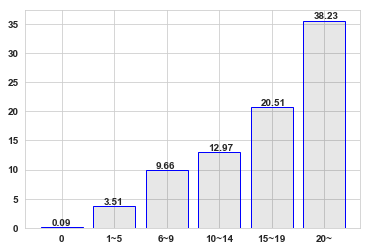

In [43]:
# "스테이지 구분" 별 불꽃 평균 사용량 분포를 그래프
y_pos = np.arange(len(fire['스테이지 구분']))
a=fire['mean']
plt.bar(y_pos,a, color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
plt.xticks(y_pos,fire['스테이지 구분'])
# barplot 위에 각각 레이블 만들기
label = [0.09, 3.51, 9.66, 12.97, 20.51, 38.23]
for i in range(len(y_pos)):
    plt.text(x = y_pos[i]-0.2 , y = a[i]+0.3, s = label[i], size = 10)

**5. "스테이지 구분" 별 획득한 불꽃을 모두 다 사용한 유저수를 계산해주세요.**

* 13: 획득한 불꽃 총 개수
* 14: 사용한 불꽃 총 개수

In [44]:
# 획득한 불꽃 총개수와 사용한 불꽃 총 개수가 같은 사람들 스테이지 구분별 추출
a=data[['스테이지 구분',13,14]]
a=a.loc[a[13] != 0]
a=a[a[13]-a[14]==0][['스테이지 구분',13,14]]
a.head()

,스테이지 구분,13,14
0,20~,41,41
50,15~19,26,26
64,15~19,25,25
75,15~19,32,32
79,20~,49,49


In [45]:
# "스테이지 구분" 별 획득한 불꽃을 모두 다 사용한 유저수를 계산
users=a.groupby('스테이지 구분')[13].count().reset_index(name='counts')
users=users.reindex([0,3,5,1,2,4])
users.index = range(len(users))
users

,스테이지 구분,counts
0,0,9
1,1~5,398
2,6~9,334
3,10~14,363
4,15~19,525
5,20~,978


**6. "스테이지 구분" 별 획득한 불꽃을 모두 다 사용한 유저 중 루비로 불꽃을 충전한 유저수를 계산해주세요.**

* 18: 불꽃 충전에 사용한 루비량

In [46]:
# 획득한 불꽃 총개수와 사용한 불꽃 총 개수가 같은 사람들 스테이지 구분별 
# + 뿔꽃 충전에 사용한 루비량이 있는 유저들만 추출
a=data[['스테이지 구분',13,14,18]]
a=a.loc[a[13] != 0]
a=a[a[13]-a[14]==0][['스테이지 구분',13,14,18]]
a=a.loc[a[18] != 0]
a.head()

,스테이지 구분,13,14,18
240,20~,50,50,10
480,20~,38,38,10
662,20~,58,58,20
1156,20~,78,78,20
1874,20~,53,53,10


In [47]:
# "스테이지 구분" 별 획득한 불꽃을 모두 다 사용한 유저 중 루비로 불꽃을 충전한 유저수
users=a.groupby(['스테이지 구분'])[18].count().reset_index(name='counts')
users=users.reindex([3,0,1,2])
users.index = range(len(users))
users

,스테이지 구분,counts
0,6~9,1
1,10~14,10
2,15~19,18
3,20~,97


**7. D+14일차 접속여부를 '장기접속율' 이라고 명명할 때, '장기접속율'에 영향을 주는 변수를 계산해 주세요**
  
  - 샘플데이터가 변형과 생략을 거쳤기 때문에, 정답이 없습니다. 부담없이 진행해주세요.
  - 방법론은 무엇이든 무관하며, 방법론은 2개를 비교하여, 더 정확도가 높다고 생각하는 방법론으로 진행해주세요 (최대 2개까지만 비교)
  - 비교한 2개의 방법론들이 무엇인지
  - 최종 방법론을 채택하게 된 이유
  - 변수를 영향력이 높은 순으로 나열 (도식화)
  - 도출된 결과를 토대로 장기접속율을 올리기 위한 방법에 대한 제언
  

#### 사용한 모델
* Logistic Regression (최종 선택)
* Xgboost

In [48]:
# data 다시 불러오기
data = pd.read_csv("line_studio_nru_data.csv", sep=",", header=None)
data.columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
# data 2는 가변수가 너무 많아져 제외, 21은 구매 품목명이므로 제외, 22는 na값이 너무 많아서 제외
data=data.drop([2,21,22],axis=1)
# NA 값 제거
data=data.dropna(subset=[11])

In [49]:
# 가변수 생성하기
# 1: os 타입
# 3: 로그인 타입
# 국가 타입도 가변수 만들시 모델 score가 올라가나 과적합의 염려로 제외
df = pd.get_dummies(data, columns=[1,3], drop_first=True)

In [50]:
df.columns.values

array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       '1_iOS', '3_LINE'], dtype=object)

In [51]:
# Train, Test 데이터 나누기 (8:2)
Y=df[10] 
X=df[[4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       '1_iOS', '3_LINE']]
# X,Y의 각각 train, test 데이터 생성
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#### LogisticRegression

- Y: D+14일차 접속여부 (0,1) 
- X: 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,'1_iOS', '3_LINE'

이진데이터를 예측하는 일이기 때문에 상관분석(연속형)을 쓸 수 없다.
Logistic Regression은 Y가 범주형 변수를 다루고
X측에 연속형 예측변수, 범주형 예측변수를 사용할 수 있기 때문에 적절하다고 할 수 있다. 

In [52]:
# LogisticRegression
logmodel = LogisticRegression()
# 모델 성능평가
logmodel.fit(X_train,Y_train)
logmodel.score(X_test, Y_test)

0.9012704174228675

In [53]:
# LogisticRegression 모델 Coefficient 값 
parameters = logmodel.coef_
parameters

array([[ 3.59559075e-01,  2.95798776e-01,  6.48329654e-01,
         1.19714656e+00,  1.11409576e+00,  1.94301711e+00,
         1.67719574e-04,  1.85433821e-03, -4.73281337e-03,
         9.83329474e-03, -9.11179659e-03,  6.28000568e-03,
        -6.61300487e-03, -6.67274375e-03, -1.39488458e-03,
         4.16215298e-04,  7.93459696e-02,  4.37950019e-01]])

In [54]:
# Coefficient 값 'e-##' 정리
print(3.59559075e-01,  2.95798776e-01,  6.48329654e-01,
         1.19714656e+00,  1.11409576e+00,  1.94301711e+00,
         1.67719574e-04,  1.85433821e-03, -4.73281337e-03,
         9.83329474e-03, -9.11179659e-03,  6.28000568e-03,
        -6.61300487e-03, -6.67274375e-03, -1.39488458e-03,
         4.16215298e-04,  7.93459696e-02,  4.37950019e-01)

0.359559075 0.295798776 0.648329654 1.19714656 1.11409576 1.94301711 0.000167719574 0.00185433821 -0.00473281337 0.00983329474 -0.00911179659 0.00628000568 -0.00661300487 -0.00667274375 -0.00139488458 0.000416215298 0.0793459696 0.437950019


### LogisticRegression: D+14일차(Y) 영향력이 높은 변수순(X)

순위 | 변수 | Coefficient
----|-------------|--------------
1 | 변수9 (D+11) | 1.9430
2 | 변수7 (D+7) | 1.1971
3 | 변수8 (D+9) | 1.1141
4 | 변수6 (D+5) | 0.6483
5 | 로그인 타입 (L*) | 0.4379
6 | 변수4(D+1) | 0.3596
7 | 변수5 (D+3) | 0.2958

- D+ 접속여부가 가장 많은 영향력을 주는 것으로 보아 계속 들어온 사람이 앞으로도 많이 들어올 확률이 크다는 것을 알 수 있다. 
- 로지스틱 회귀분석에서 '로그인 타입'이 '접속여부' 다음으로 크게 Y에 영향을 준다. 따라서 Guest보단 L*을 통해 들어온 사람들이 더 오래 게임을 한다는 것을 알 수 있다. 
- 장기접속율을 올리기 위해서는 우선적으로 L* 유저들을 공략하는 것이 좋고, 우선적으로 많은 사람들에게 홍보를 통해 신규가입자수를 늘리는 것이 장기접속율을 높일 수 있는 가장 보편적인 방법이다. 

#### Xgboost 

- Y: D+14일차 접속여부 (0,1) 
- X: 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, '1_iOS', '3_LINE'

앙상블 방법론 또한 Y가 범주형 변수를 예측할 수 있고
X측에 연속형 예측변수, 범주형 예측변수를 이용할 수 있기 때문에 적절하다고 할 수 있다. 
앙상블 방법론 중에서도 Xgboost를 이용하였다. 약한 예측모형들을 결함하여 강한 예측 모형을 만드는 알고리즘으로 이용할 수 있는 모델이기에 좋은 적합도를 낼 것으로 기대되어 사용하였다.

In [55]:
# 의사결정나무 모델 하나인 XGBoost 모델 이용
xgb = XGBRegressor(n_estimators=98, 
                   learning_rate=0.05,
                   max_depth=3, 
                   max_features='auto',
                   min_samples_leaf=5,
                   min_samples_split=10, 
                   warm_start = False, 
                   loss='ls',
                   random_state=10)

xgb.fit(X_train,Y_train)
xgb.score(X_test,Y_test)

0.6059601814632156

In [56]:
parameters = xgb.feature_importances_
parameters

array([0.00339262, 0.00429899, 0.01376886, 0.0595508 , 0.05732919,
       0.8431735 , 0.00228587, 0.00326538, 0.00151938, 0.0023495 ,
       0.00133144, 0.00097017, 0.        , 0.00098669, 0.00116403,
       0.00162901, 0.00101619, 0.00196832], dtype=float32)

###  XGBoost: D+14일차(Y) 영향력이 높은 변수순(X)

순위 | 변수 | Feature importances
----|-------------|--------------
1 | 변수9 (D+11) | 0.84317
2 | 변수7 (D+7) | 0.05955
3 | 변수8 (D+9) | 0.05733
4 | 변수6 (D+5) | 0.01377
5 | 변수5 (D+3) | 0.00429
6 | 변수4 (D+1) | 0.00339
7 | 변수12 (마지막으로 도전한 스테이지) | 0.00327

- XGBosst도 마찬가지로 D+ 접속여부가 가장 많은 영향력을 주는 것을 알 수 있다. 
- 여기서는 접속여부 다음으로 '마지막으로 도전한 스테이지'가 Y에 영향력을 주는 것을 알 수 있다. 

In [57]:
data[1].unique()

array(['Android', 'iOS'], dtype=object)

###  Score 값이 Logistic Regression(0.901)이 더 높으므로 Logistic Regression 모델을 쓰는 것이 더 좋다.

- 장기접속율을 올리기 위해서는 우선적으로 Line 유저들을 공략하는 것이 좋고, 우선적으로 많은 사람들에게 홍보를 통해 신규가입자수를 늘리는 것이 장기접속율을 높일 수 있는 가장 보편적인 방법이다.
- 계수값이 작게 나오긴 했지만 높은 변수순 8위로 'os타입'(0.07934) 영향력이 있다. 이 것을 보아 Android 보다 ios이용자가 좀 더 장기접속자가 많다는 것을 알 수 있다. 따라서 iphone을 더 많이 이용하는 나라가 게임 유저가 많은지를 조사하는 것도 새로운 정보를 얻을 수 있는 기반이 될 수 있다.